In [127]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from matplotlib import pyplot as plt
plt.style.use('fivethirtyeight')

In [128]:
df = pd.read_csv('size_product_transactions.csv')

In [129]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

In [130]:
df['size'].describe()

count     348813
unique        25
top          8-M
freq       93088
Name: size, dtype: object

In [131]:
df.dtypes

Unnamed: 0           int64
prod_id             object
class               object
style               object
style_color         object
prod_nm             object
FISCAL_START_DT     object
SALES_UNITS        float64
SALES_AMT          float64
pid                 object
size                object
dtype: object

In [132]:
print(f"There are a total of {len(df)} products on the table ")
print("Split by Size they look like this - across all product classes")
print("**********")
size_df = pd.DataFrame(df['size'].value_counts())
size_df['percent_splits'] = size_df.apply(lambda x: 100 * x / float(x.sum()))
size_df

There are a total of 348813 products on the table 
Split by Size they look like this - across all product classes
**********


size  percent_splits
8-M    93088       26.687079
7-M    72678       20.835806
9-M    69920       20.045124
6-M    39019       11.186223
10-M   36181       10.372607
8H-M   12161        3.486395
7H-M   12022        3.446546
6H-M    6748        1.934561
9H-M    6339        1.817306
11-M     170        0.048737
5-M      108        0.030962
7         88        0.025228
5H-M      87        0.024942
8         87        0.024942
12-M      32        0.009174
6         29        0.008314
9         25        0.007167
10        20        0.005734
7H         2        0.000573
10H-M      2        0.000573
11H-M      2        0.000573
11         2        0.000573
9H         1        0.000287
8H         1        0.000287
5          1        0.000287

*********************RECORDS BY CLASS*************************
NON APPAREL FOOTWEAR WMNS SEAS    211388
NON APPAREL FOOTWEAR WMNS SHOE     94358
NON APPAREL FOOTWEAR WMNS SAND     39876
NON APPAREL FOOTWEAR WMNS BOOT      3191
Name: class, dtype: int64


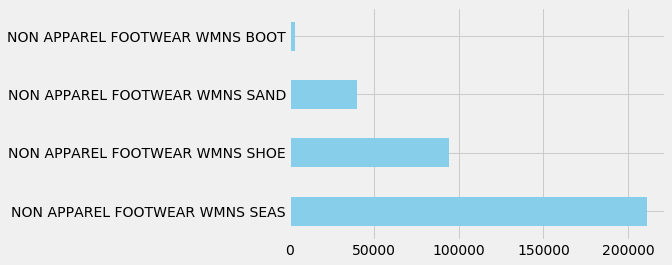

In [142]:
print("*********************RECORDS BY CLASS*************************")
print(df['class'].value_counts())
df['class'].value_counts().plot(kind='barh', color='skyblue');

In [134]:
#convert to date
df['FISCAL_START_DT'] = pd.to_datetime(df.FISCAL_START_DT)

In [135]:
print(df.FISCAL_START_DT.describe())
print("*********")
print("*********")
print("*********")
total_months = round((max(df["FISCAL_START_DT"]) - min(df['FISCAL_START_DT']))/np.timedelta64(1, 'M'))
print(f"""The min datetime stamp is {min(df.FISCAL_START_DT)}, and the max is {max(df.FISCAL_START_DT)}.
Rounded: There are a total of {total_months} months""")

count                  348813
unique                     52
top       2016-03-27 00:00:00
freq                    15801
first     2016-01-31 00:00:00
last      2017-01-22 00:00:00
Name: FISCAL_START_DT, dtype: object
*********
*********
*********
The min datetime stamp is 2016-01-31 00:00:00, and the max is 2017-01-22 00:00:00.
Rounded: There are a total of 12 months


In [136]:
# profile_df= pd.DataFrame()
# for i in list(df['class'].value_counts().index):
#     groupby_size = df[df['class']==i].groupby('size')
#     handler_df = pd.DataFrame(groupby_size['SALES_UNITS'].sum())
#     handler_df = handler_df.T
#     handler_df['class'] = i
#     profile_df= profile_df.append(handler_df)

Total units by size


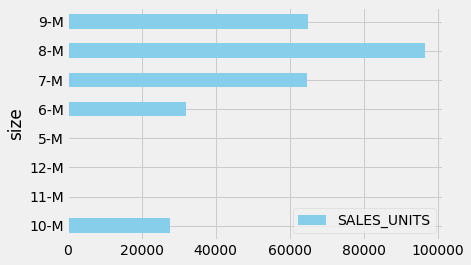

In [137]:
groupbySize = df[df['class']=="NON APPAREL FOOTWEAR WMNS SEAS"].groupby('size')
class_size_profile=pd.DataFrame(groupbySize['SALES_UNITS'].sum())
print("Total units by size")
class_size_profile.plot(kind='barh',color='skyblue');

In [138]:
class_size_profile['percent_splits']=class_size_profile.apply(lambda x: 100 * x / float(x.sum()))
class_size_profile

SALES_UNITS  percent_splits
size                             
10-M      27773.0        9.712164
11-M         20.0        0.006994
12-M          9.0        0.003147
5-M          34.0        0.011890
6-M       32012.0       11.194534
7-M       64740.0       22.639451
8-M       96568.0       33.769640
9-M       64805.0       22.662181

We need to adopt a strategy of deleting the sizes that contribute to less than 1% in sales through the year

In [143]:
# from scipy import stats
# stats.zscore(class_size_profile['SALES_UNITS'])
print(f"These sizes still contribute to {class_size_profile[class_size_profile['percent_splits']>1]['percent_splits'].sum()} in total unit sales")
class_size_profile[class_size_profile['percent_splits']>1]

These sizes still contribute to 99.977969023748 in total unit sales


SALES_UNITS  percent_splits
size                             
10-M      27773.0        9.712164
6-M       32012.0       11.194534
7-M       64740.0       22.639451
8-M       96568.0       33.769640
9-M       64805.0       22.662181

In [153]:
def get_profile_for_class(input_df=df, cls="NON APPAREL FOOTWEAR WMNS SEAS",size_col = 'size',
                          start_timestamp=min(df["FISCAL_START_DT"]),
                          end_timestamp=max(df["FISCAL_START_DT"])):
    """
    Takes an input dataframe, subsets for the start timestamp and the end timestamp. Creates a ByGroup on Size and
    then calulates the total sales units by size. Also calculates % of total units and removes sizes where 
    %total units is less than 1%
    
    Parameters:
    ----------
    cls: Optional; The product class interested in
    input_df: DataFrame; Required. Input dataframe to manipulate
    start_timestamp: Optional; The Starting timestamp 
    end_timestamp: Optional; The Ending timestamp 
    """
    sub_df= input_df[(input_df["FISCAL_START_DT"]>= start_timestamp) &( input_df["FISCAL_START_DT"] <=end_timestamp)]
    groupbySize = sub_df[sub_df['class']==cls].groupby(size_col)
    units_df=pd.DataFrame(groupbySize['SALES_UNITS'].sum())
    units_df['percent_units']=100*units_df['SALES_UNITS']/units_df['SALES_UNITS'].sum()
    units_df['product_class'] = cls
    units_df=units_df[units_df['percent_units']>1]
    return units_df

In [154]:
ret_df = get_profile_for_class()

ret_df.style.bar(color='skyblue') #highlight values

In [167]:
profile_months = 1

parts = round(total_months/profile_months)
print(f"there are a total of {parts} parts if profiled by a {profile_months} month window")

there are a total of 12 parts if profiled by a 1 month window


In [168]:
size_of_part_in_days  = round(((max(df["FISCAL_START_DT"]) - min(df['FISCAL_START_DT'])).days)/parts)

In [169]:
size_of_part_in_days

30

In [170]:
from datetime import timedelta

In [171]:
min(df["FISCAL_START_DT"])+timedelta(days=size_of_part_in_days)

Timestamp('2016-03-01 00:00:00')

In [172]:
#generate time ranges for the profile generation
date_ranges=[]
for i in np.arange(round(parts)):
    cutover_date = min(df["FISCAL_START_DT"])+(timedelta(days=size_of_part_in_days)*(i+1))
    date_ranges.append(cutover_date)
#     if (max(df["FISCAL_START_DT"]) - date_ranges[-1] < timedelta(days=size_of_part_in_days)):
#         date_ranges.pop()
#     else:
#         pass
date_ranges.insert(0,min(df['FISCAL_START_DT']))
date_ranges.insert(len(date_ranges),max(df['FISCAL_START_DT']))

In [173]:
date_ranges

[Timestamp('2016-01-31 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2016-04-30 00:00:00'),
 Timestamp('2016-05-30 00:00:00'),
 Timestamp('2016-06-29 00:00:00'),
 Timestamp('2016-07-29 00:00:00'),
 Timestamp('2016-08-28 00:00:00'),
 Timestamp('2016-09-27 00:00:00'),
 Timestamp('2016-10-27 00:00:00'),
 Timestamp('2016-11-26 00:00:00'),
 Timestamp('2016-12-26 00:00:00'),
 Timestamp('2017-01-25 00:00:00'),
 Timestamp('2017-01-22 00:00:00')]

In [174]:
def _eliminate_final_cutdate(size_of_part_in_days):
    if (date_ranges[-1] - date_ranges[-2] < timedelta(days=size_of_part_in_days)):
        date_ranges.pop()
    else:
        pass

In [175]:
#apply finaldate cut-off check
_eliminate_final_cutdate(size_of_part_in_days)

In [176]:
date_ranges

[Timestamp('2016-01-31 00:00:00'),
 Timestamp('2016-03-01 00:00:00'),
 Timestamp('2016-03-31 00:00:00'),
 Timestamp('2016-04-30 00:00:00'),
 Timestamp('2016-05-30 00:00:00'),
 Timestamp('2016-06-29 00:00:00'),
 Timestamp('2016-07-29 00:00:00'),
 Timestamp('2016-08-28 00:00:00'),
 Timestamp('2016-09-27 00:00:00'),
 Timestamp('2016-10-27 00:00:00'),
 Timestamp('2016-11-26 00:00:00'),
 Timestamp('2016-12-26 00:00:00'),
 Timestamp('2017-01-25 00:00:00')]

In [184]:
#subset dateranges and fetch profile
profile_df=pd.DataFrame()
for i  in range(len(date_ranges)):
    start_timestp = date_ranges[i]
    if i<len(date_ranges)-1:
        end_timestp = date_ranges[i+1] #get next timestamp and set as the end timestamp
        print(f"INFO: Now processing {profile_months} month profile between - {start_timestp,end_timestp}")
        result_profile_df=get_profile_for_class(start_timestamp= start_timestp,  end_timestamp=end_timestp)
        result_profile_df['start_date'] = start_timestp
        result_profile_df['end_date'] = end_timestp
        result_profile_df['profile_months'] = profile_months
        profile_df = profile_df.append(result_profile_df)
    else:
        pass

INFO: Now processing 1 month profile between - (Timestamp('2016-01-31 00:00:00'), Timestamp('2016-03-01 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-03-01 00:00:00'), Timestamp('2016-03-31 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-03-31 00:00:00'), Timestamp('2016-04-30 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-04-30 00:00:00'), Timestamp('2016-05-30 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-05-30 00:00:00'), Timestamp('2016-06-29 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-06-29 00:00:00'), Timestamp('2016-07-29 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-07-29 00:00:00'), Timestamp('2016-08-28 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-08-28 00:00:00'), Timestamp('2016-09-27 00:00:00'))
INFO: Now processing 1 month profile between - (Timestamp('2016-09-27 00

In [ ]:
							
					3Months, 4months,5months, 6months,9months, Full		
							
	Size	Sales Units	% Sales	Product Class	Profile Months	Start Date	End Date
							

In [202]:

def create_rolling_profiles(profile_month_list,product_class,df):

    profile_df=pd.DataFrame()
    for profile_months in profile_month_list:

        parts = round(total_months/profile_months)
        print(f"INFO:There are a total of {parts} parts if profiled by a {profile_months} month window")
        size_of_part_in_days  = round(((max(df["FISCAL_START_DT"]) - min(df['FISCAL_START_DT'])).days)/parts)

        #generate time ranges for the profile generation
        date_ranges=[]
        for i in np.arange(round(parts)):
            cutover_date = min(df["FISCAL_START_DT"])+(timedelta(days=size_of_part_in_days)*(i+1))
            date_ranges.append(cutover_date)
        date_ranges.insert(0,min(df['FISCAL_START_DT']))
        date_ranges.insert(len(date_ranges),max(df['FISCAL_START_DT']))

        def _eliminate_final_cutdate(size_of_part_in_days):
            if (date_ranges[-1] - date_ranges[-2] < timedelta(days=size_of_part_in_days)):
                date_ranges.pop()
            else:
                pass

        _eliminate_final_cutdate(size_of_part_in_days)

        #subset dateranges and fetch profile
        for i  in range(len(date_ranges)):
            start_timestp = date_ranges[i]
            if i<len(date_ranges)-1:
                end_timestp = date_ranges[i+1] #get next timestamp and set as the end timestamp
                print(f"INFO: Now processing {profile_months} month profile between - {start_timestp,end_timestp}")
                result_profile_df=get_profile_for_class(start_timestamp= start_timestp,  end_timestamp=end_timestp,cls=product_class)
                result_profile_df['start_date'] = start_timestp
                result_profile_df['end_date'] = end_timestp
                result_profile_df['profile_months'] = profile_months
                profile_df = profile_df.append(result_profile_df)
            else:
                pass
    return profile_df

In [203]:
return_df = create_rolling_profiles([3,4,5],"NON APPAREL FOOTWEAR WMNS SEAS",df)

INFO:There are a total of 4 parts if profiled by a 3 month window
INFO: Now processing 3 month profile between - (Timestamp('2016-01-31 00:00:00'), Timestamp('2016-04-29 00:00:00'))
INFO: Now processing 3 month profile between - (Timestamp('2016-04-29 00:00:00'), Timestamp('2016-07-27 00:00:00'))
INFO: Now processing 3 month profile between - (Timestamp('2016-07-27 00:00:00'), Timestamp('2016-10-24 00:00:00'))
INFO: Now processing 3 month profile between - (Timestamp('2016-10-24 00:00:00'), Timestamp('2017-01-21 00:00:00'))
INFO:There are a total of 3 parts if profiled by a 4 month window
INFO: Now processing 4 month profile between - (Timestamp('2016-01-31 00:00:00'), Timestamp('2016-05-29 00:00:00'))
INFO: Now processing 4 month profile between - (Timestamp('2016-05-29 00:00:00'), Timestamp('2016-09-25 00:00:00'))
INFO: Now processing 4 month profile between - (Timestamp('2016-09-25 00:00:00'), Timestamp('2017-01-22 00:00:00'))
INFO:There are a total of 2 parts if profiled by a 5 mon

In [204]:
return_df

SALES_UNITS  percent_units                   product_class start_date  \
size                                                                          
10-M      10603.0       9.100975  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
6-M       13598.0      11.671702  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
7-M       28831.0      24.746790  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
8-M       38918.0      33.404862  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
9-M       24548.0      21.070521  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
10-M      17075.0      10.116300  NON APPAREL FOOTWEAR WMNS SEAS 2016-04-29   
6-M       18352.0      10.872875  NON APPAREL FOOTWEAR WMNS SEAS 2016-04-29   
7-M       35808.0      21.214904  NON APPAREL FOOTWEAR WMNS SEAS 2016-04-29   
8-M       57429.0      34.024540  NON APPAREL FOOTWEAR WMNS SEAS 2016-04-29   
9-M       40075.0      23.742942  NON APPAREL FOOTWEAR WMNS SEAS 2016-04-29   
10-M         45.0      12.195122  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
6-M          29.0       7.859079  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
7-M          63.0      17.073171  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
8-M         137.0      37.127371  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
9-M          91.0      24.661247  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
10-M         46.0      16.428571  NON APPAREL FOOTWEAR WMNS SEAS 2016-10-24   
5-M           3.0       1.071429  NON APPAREL FOOTWEAR WMNS SEAS 2016-10-24   
6-M          30.0      10.714286  NON APPAREL FOOTWEAR WMNS SEAS 2016-10-24   
7-M          36.0      12.857143  NON APPAREL FOOTWEAR WMNS SEAS 2016-10-24   
8-M          78.0      27.857143  NON APPAREL FOOTWEAR WMNS SEAS 2016-10-24   
9-M          86.0      30.714286  NON APPAREL FOOTWEAR WMNS SEAS 2016-10-24   
10-M      16854.0       9.207220  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
6-M       21022.0      11.484168  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
7-M       44714.0      24.426939  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
8-M       61276.0      33.474641  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
9-M       39179.0      21.403208  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
10-M      12319.0      10.388241  NON APPAREL FOOTWEAR WMNS SEAS 2016-05-29   
6-M       12772.0      10.770243  NON APPAREL FOOTWEAR WMNS SEAS 2016-05-29   
7-M       23697.0      19.982966  NON APPAREL FOOTWEAR WMNS SEAS 2016-05-29   
8-M       40640.0      34.270487  NON APPAREL FOOTWEAR WMNS SEAS 2016-05-29   
9-M       29109.0      24.546742  NON APPAREL FOOTWEAR WMNS SEAS 2016-05-29   
10-M         54.0      15.211268  NON APPAREL FOOTWEAR WMNS SEAS 2016-09-25   
5-M           6.0       1.690141  NON APPAREL FOOTWEAR WMNS SEAS 2016-09-25   
6-M          37.0      10.422535  NON APPAREL FOOTWEAR WMNS SEAS 2016-09-25   
7-M          49.0      13.802817  NON APPAREL FOOTWEAR WMNS SEAS 2016-09-25   
8-M         104.0      29.295775  NON APPAREL FOOTWEAR WMNS SEAS 2016-09-25   
9-M         104.0      29.295775  NON APPAREL FOOTWEAR WMNS SEAS 2016-09-25   
10-M      27678.0       9.701673  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
6-M       31950.0      11.199091  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
7-M       64639.0      22.657217  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
8-M       96347.0      33.771482  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
9-M       64623.0      22.651608  NON APPAREL FOOTWEAR WMNS SEAS 2016-01-31   
10-M         91.0      14.021572  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
6-M          59.0       9.090909  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
7-M          99.0      15.254237  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
8-M         215.0      33.127889  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   
9-M         177.0      27.272727  NON APPAREL FOOTWEAR WMNS SEAS 2016-07-27   

       end_date  profile_months  
size                             
10-M 2016-04-29               3  
6-M  2016-04-29               3 